# LM Dictionary vs. finbert vs. T5

In [1]:
%config InlineBackend.figure_format='retina'
import logging
from ekorpkit import eKonf

logging.basicConfig(level=logging.INFO)
print(eKonf.__version__)

0.1.32+10.gbc2a912.dirty


## Prepare `financial_phrasebank` dataset

In [3]:
ds_name = "financial_phrasebank"
cfg = eKonf.compose('dataset/simple=' + ds_name)
cfg.data_dir = '../data/' + ds_name
cfg.io.overwrite = True
cfg.io.calculate_stats = True
db = eKonf.instantiate(cfg)

apply len_bytes to num_bytes:   0%|          | 0/1445 [00:00<?, ?it/s]

apply len_bytes to num_bytes:   0%|          | 0/452 [00:00<?, ?it/s]

apply len_bytes to num_bytes:   0%|          | 0/362 [00:00<?, ?it/s]

In [2]:
ds_cfg = eKonf.compose('dataset')
ds_cfg.name = 'financial_phrasebank'
ds_cfg.path.cache.uri = 'https://github.com/entelecheia/ekorpkit-book/raw/main/data/financial_phrasebank.zip'
ds_cfg.data_dir = ds_cfg.path.cached_path
ds_cfg.verbose = False
ds = eKonf.instantiate(ds_cfg)
print(ds)

Dataset : financial_phrasebank


## Instantiating a sentiment analyser class with `financial_phrasebank` dataset

In [4]:
model_cfg = eKonf.compose('model/sentiment=lm')

cfg = eKonf.compose(config_group='pipeline')
cfg.verbose = True
cfg.data.dataset = ds_cfg
cfg._pipeline_ = ['predict']
cfg.predict.model = model_cfg
cfg.predict.output_dir = "../data/predict"
cfg.predict.output_file = f'{ds_cfg.name}.parquet'
cfg.num_workers = 1
df = eKonf.instantiate(cfg)
df

Predicting [text]:   0%|          | 0/1445 [00:00<?, ?it/s]

Predicting [text]:   0%|          | 0/362 [00:00<?, ?it/s]

Predicting [text]:   0%|          | 0/452 [00:00<?, ?it/s]

{'train':          id                                               text    labels  \
 index                                                                      
 0       655  Customers in a wide range of industries use ou...   neutral   
 1       634  The writing and publication of Lemmink+ñinen -...   neutral   
 2      1030  Sullivan said some of the boards `` really inv...   neutral   
 3       317  The six breweries recorded a 5.2 percent growt...  positive   
 4       868  In the second quarter of 2010 , the company 's...  positive   
 ...     ...                                                ...       ...   
 1440    136  In the fourth quarter of 2009 , Orion 's net p...  positive   
 1441   2170  Profit for the period totalled EUR 1.1 mn , do...  negative   
 1442    344  The diluted loss per share narrowed to EUR 0.2...  positive   
 1443    573  LKAB , headquartered in Lulea , Sweden , is a ...   neutral   
 1444   1768  The EBRD is using its own funds to provide a 2...   n

In [5]:
print(cfg.predict.output_dir)
print(cfg.predict.output_file)

../data/predict
financial_phrasebank.parquet


Accuracy:  0.6423196104471005
Precison:  0.6335214835254505
Recall:  0.6423196104471005
F1 Score:  0.5979784064056457
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    negative       0.38      0.36      0.37       303
     neutral       0.68      0.89      0.77      1386
    positive       0.65      0.19      0.29       570

    accuracy                           0.64      2259
   macro avg       0.57      0.48      0.48      2259
weighted avg       0.63      0.64      0.60      2259



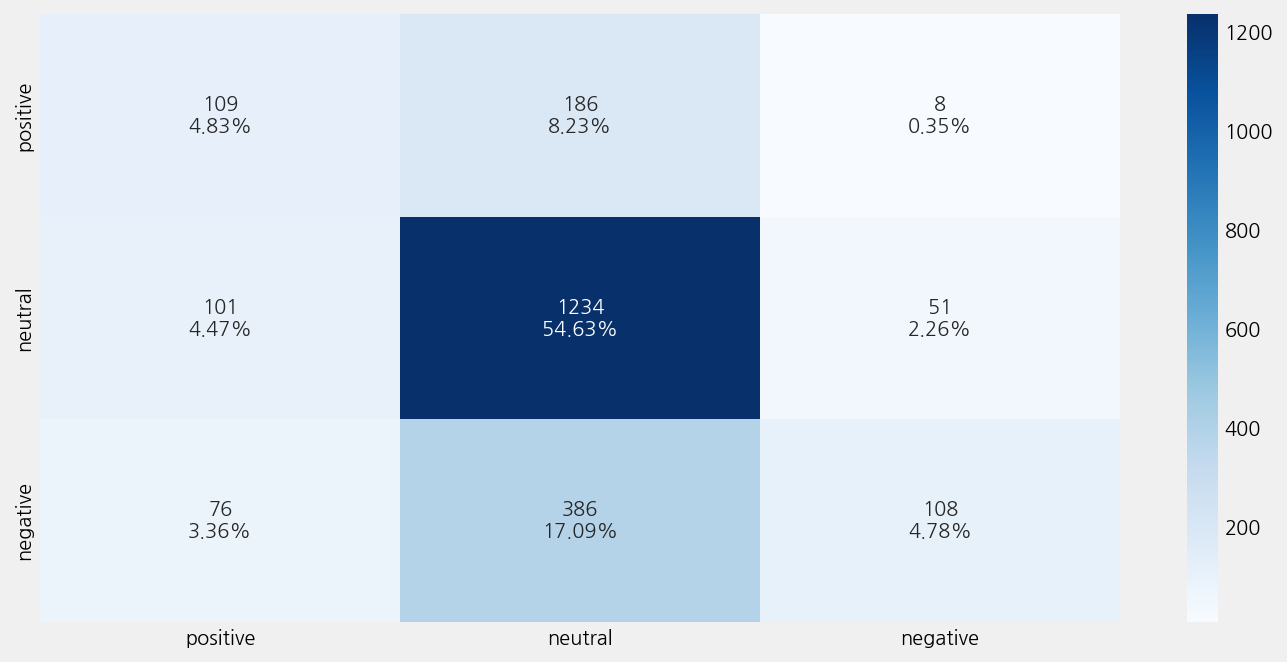

In [6]:
eval_cfg = eKonf.compose('model/eval=classification')
eval_cfg.columns.actual = 'labels'
eval_cfg.columns.predicted = 'polarity_label'
eval_cfg.labels = ['positive','neutral','negative']
eval_cfg.data_dir = '../data/predict'
eval_cfg.data_file = 'financial_phrasebank-*.parquet'
eval_cfg.output_dir = '../data/eval'
# eval_cfg.method.average = None
# eKonf.print(eval_cfg)
eKonf.instantiate(eval_cfg)

## Instantiating a transformer classficiation model with `financial_phrasebank` dataset

In [7]:
overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=finbert',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 2
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg.labels = ['positive','neutral','negative']
model_cfg._method_ = ['train']
eKonf.instantiate(model_cfg)

  0%|          | 0/1445 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

wandb: Currently logged in as: entelecheia. Use `wandb login --relogin` to force relogin


Running Epoch 0 of 2:   0%|          | 0/46 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

Training loss,▁
acc,▁█
eval_loss,█▁
global_step,▁▂█
lr,▁
mcc,▁█
train_loss,▁█
Training loss,0.26315
acc,0.8232
eval_loss,0.3609
global_step,92


  0%|          | 0/452 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy:  0.8030973451327433
Precison:  0.8594311804274855
Recall:  0.8030973451327433
F1 Score:  0.7621939239083855
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    negative       1.00      0.03      0.06        61
     neutral       0.95      0.94      0.94       277
    positive       0.57      0.88      0.69       114

    accuracy                           0.80       452
   macro avg       0.84      0.62      0.57       452
weighted avg       0.86      0.80      0.76       452



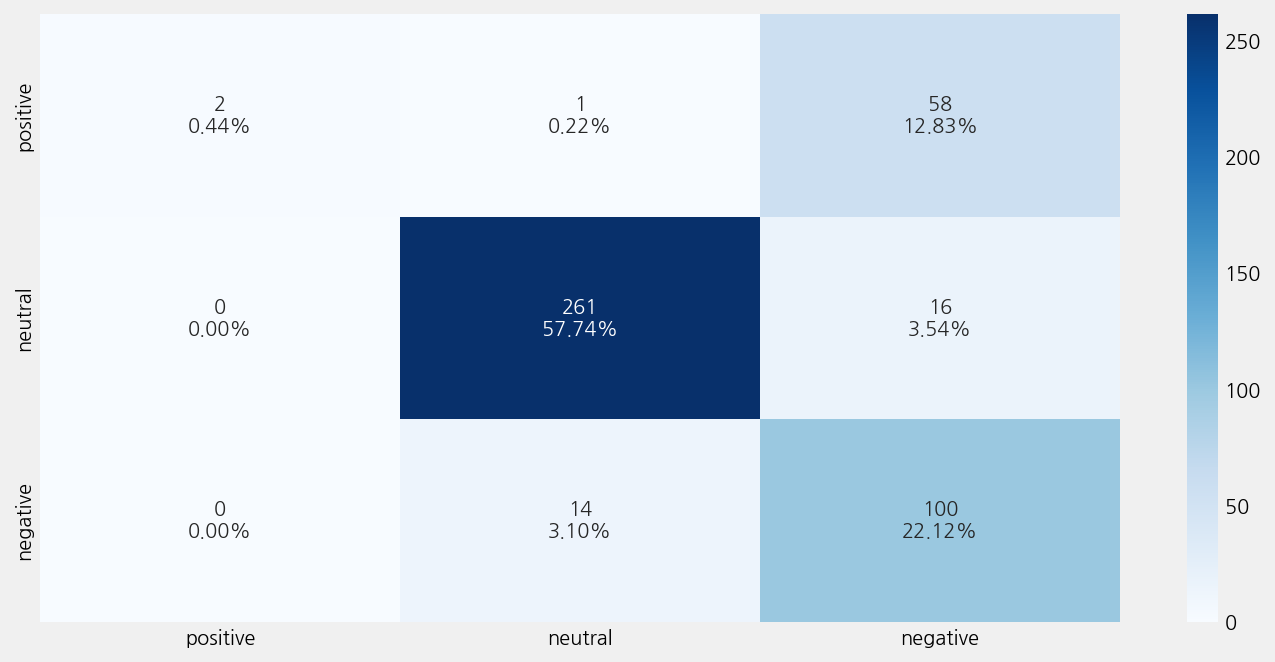

In [8]:
overrides=[
    '+model/transformer=classification',
    '+model/transformer/pretrained=finbert',
]
model_cfg = eKonf.compose('model/transformer=classification', overrides)
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 2
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 32
model_cfg.config.eval_batch_size = 32
model_cfg.labels = ['positive','neutral','negative']
model_cfg._method_ = ['eval']
eKonf.instantiate(model_cfg)

## Instantiating a T5 classficiation model with `financial_phrasebank` dataset

  0%|          | 0/1445 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/362 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.10657118299116662}


Generating outputs:   0%|          | 0/57 [00:00<?, ?it/s]

Accuracy:  0.9491150442477876
Precison:  0.9498340427489275
Recall:  0.9491150442477876
F1 Score:  0.949335707792895
Model Report: 
___________________________________________________
              precision    recall  f1-score   support

    negative       0.91      0.95      0.93        61
     neutral       0.97      0.96      0.97       277
    positive       0.91      0.93      0.92       114

    accuracy                           0.95       452
   macro avg       0.93      0.95      0.94       452
weighted avg       0.95      0.95      0.95       452



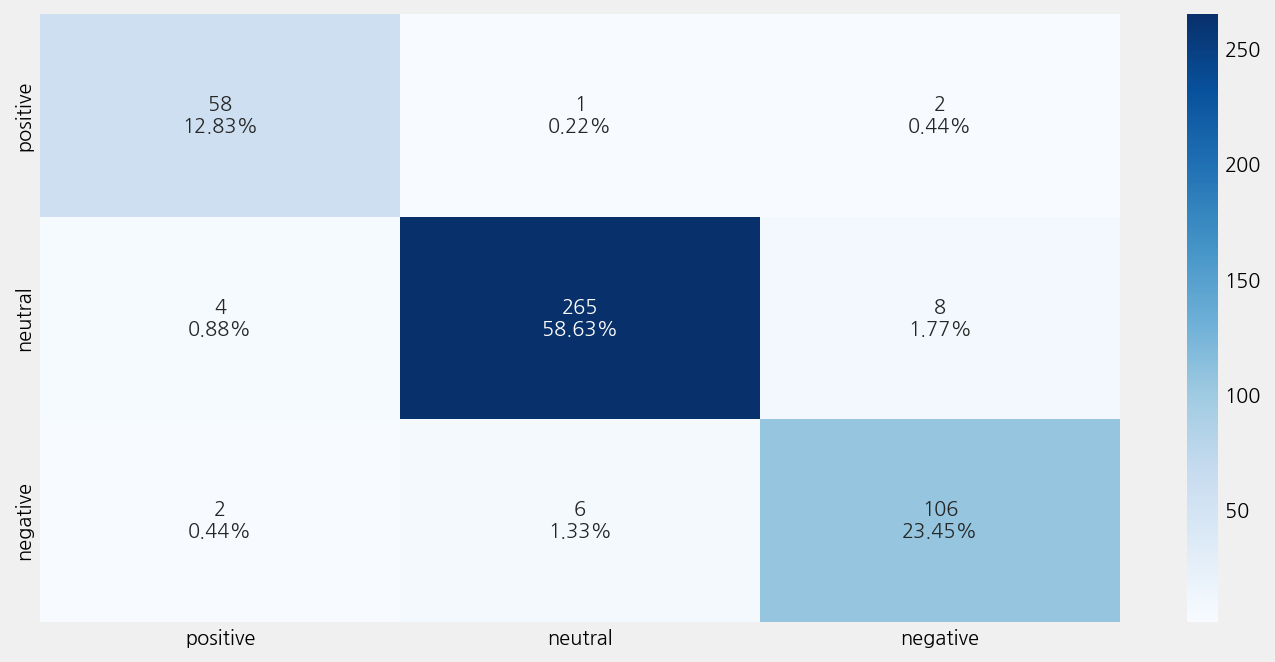

In [9]:
overrides=[
    '+model/transformer=t5_classification_with_simple',
    '+model/transformer/pretrained=t5-base',
]
model_cfg = eKonf.compose('model/transformer=t5_classification_with_simple', overrides)
model_cfg.dataset = ds_cfg
model_cfg.verbose = False
model_cfg.config.num_train_epochs = 2
model_cfg.config.max_seq_length = 256
model_cfg.config.train_batch_size = 8
model_cfg.config.eval_batch_size = 8
model_cfg.labels = ['positive','neutral','negative']
model_cfg._method_ = ['train', 'eval']
eKonf.instantiate(model_cfg)